# 1) Load dependencies, set session parameters, and load the CIVAR-10 data

In [11]:
## Basic PyTorch functionality
import torch
from torch import nn
from torch.utils.data import DataLoader

## CPU data structures
import pandas as pd
import numpy as np

## Public datasets
import torchvision.datasets as datasets
import torchvision.transforms as transforms

## Classical ML-frameworks
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

## Plotting
import matplotlib.pyplot as plt

## Custom modules
import jm_pytorch_tutorials as jpt
from jm_pytorch_tutorials.models import MLP, CNN, SklearnModelWrapper

In [2]:
# Hyperparameters for session
batch_size = 64
device = jpt.utils.get_device()
print(f"Using device: {device}")

Using device: mps


In [8]:
# Dataset downloading, normalization, adding to train/test splits

download=False

# Transform for normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # mean, std for RGB
])

# Download CIFAR-10 trainset
train_set = datasets.CIFAR10(
    root='./data', 
    train=True,
    download=download, 
    transform=transform)

train_loader = DataLoader(
    train_set, 
    batch_size=64,
    shuffle=True, 
    num_workers=2)

# Download CIFAR-10 testset
test_set = datasets.CIFAR10(
    root='./data',
    train=False,            
    download=download,
    transform=transform
)

# Wrap in a DataLoader
test_loader = DataLoader(
    test_set,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

# 2) Training/Testing PyTorch and Sklearn models

In [9]:
## PyTorch Train/Test

# Instantiate Pytorch models
torch_models = {
    "MLP": MLP(input_shape=(3, 32, 32), hidden_dims=[512, 256], num_classes=10),
    "CNN": CNN(input_shape=(3, 32, 32), conv_channels=[32, 64], fc_dims=[256], num_classes=10),
}

# Loop through to train/test all Pytorch models
for name, model in torch_models.items():
    # Train each Pytorch model instance
    jpt.train.train_torch_model(model, train_loader, epochs=5,
                optimizer_class=torch.optim.Adam,
                learning_rate=0.001,
                criterion=nn.CrossEntropyLoss())
    # Evaluate each trained Pytorch model on a test dataset
    print(f"Testing {name}")
    jpt.test.evaluate_torch_model(model, test_loader, 
                                  class_names=None, save_to_model=True)

Training model: MLP
Trainable parameters: 1,707,274
Epoch 1/5: Loss = 1281.2515 | Time = 14.72s
Epoch 2/5: Loss = 1119.3092 | Time = 14.57s
Epoch 3/5: Loss = 1032.7297 | Time = 14.62s
Epoch 4/5: Loss = 960.3007 | Time = 14.55s
Epoch 5/5: Loss = 896.1070 | Time = 14.56s
Total training time: 73.02s
Testing MLP
Evaluating model: MLP

Evaluation Accuracy: 51.03% | Time: 12.36s
Per-Class ROC AUC and PR AUC:
  class_0: ROC AUC = 0.911, PR AUC = 0.611
  class_1: ROC AUC = 0.938, PR AUC = 0.709
  class_2: ROC AUC = 0.824, PR AUC = 0.385
  class_3: ROC AUC = 0.835, PR AUC = 0.338
  class_4: ROC AUC = 0.851, PR AUC = 0.428
  class_5: ROC AUC = 0.859, PR AUC = 0.429
  class_6: ROC AUC = 0.918, PR AUC = 0.612
  class_7: ROC AUC = 0.889, PR AUC = 0.621
  class_8: ROC AUC = 0.933, PR AUC = 0.711
  class_9: ROC AUC = 0.914, PR AUC = 0.632

Macro ROC AUC: 0.887 | Macro PR AUC: 0.547
Training model: CNN
Trainable parameters: 1,070,794
Epoch 1/5: Loss = 1013.4599 | Time = 15.22s
Epoch 2/5: Loss = 714.84

In [13]:
## Sklearn Fit/Eval

# Flatten images and move to CPU
X_train = train_set.data.reshape((len(train_set.data), -1))  # shape: [50000, 3072]
y_train = np.array(train_set.targets)
X_test = test_set.data.reshape((len(test_set.data), -1))  # shape: [50000, 3072]
y_test = np.array(test_set.targets)

# Subsample to speed up training
X_train_small = X_train[:10000]
y_train_small = y_train[:10000]

# Instantiate wrapped Sklearn models
sklearn_models = {
    "SVM": SklearnModelWrapper(SVC(kernel='linear', probability=True)),
    "RF": SklearnModelWrapper(RandomForestClassifier(n_estimators=100, n_jobs=-1)),
    "NB": SklearnModelWrapper(GaussianNB())
}

# Loop through Sklearn models to fit/eval
for name, model in sklearn_models.items():
    model.fit(X_train_small, y_train_small)
    metrics = model.evaluate(X_test, y_test)

Training SVC
Training time: 350.78s
Evaluating SVC
Evaluating model: SVC
Training RandomForestClassifier
Training time: 2.10s
Evaluating RandomForestClassifier
Evaluating model: RandomForestClassifier
Training GaussianNB
Training time: 0.11s
Evaluating GaussianNB
Evaluating model: GaussianNB


# 3) Organizing/visualizing eval metrics

In [14]:
## Consolidate models and evaluation metrics
all_models = {** sklearn_models, **torch_models}
results = []

for name, model in all_models.items():
    results.append(model.eval_metrics)

In [15]:
## Structure results into a DataFrame if you'd like
df = pd.DataFrame([{
    "Model": r["label"],
    "Accuracy": r["accuracy"],
    "AUROC": r["auroc"],
    "AUPRC": r["auprc"],
    "Train Time (s)": r["train_time"],
    "Inference Time (s)": r["inference_time"]
} for r in results])
print(df.round(4))

                    Model  Accuracy   AUROC   AUPRC  Train Time (s)  \
0                     SVC    0.3172  0.7697  0.2910        350.7800   
1  RandomForestClassifier    0.4195  0.8278  0.4148          2.1033   
2              GaussianNB    0.2930  0.7133  0.2255          0.1094   
3                     MLP   51.0300  0.8872  0.5475         73.0202   
4                     CNN   72.5100  0.9628  0.8099         76.0022   

   Inference Time (s)  
0             34.4207  
1              0.0454  
2              0.6581  
3             12.3634  
4             12.3837  


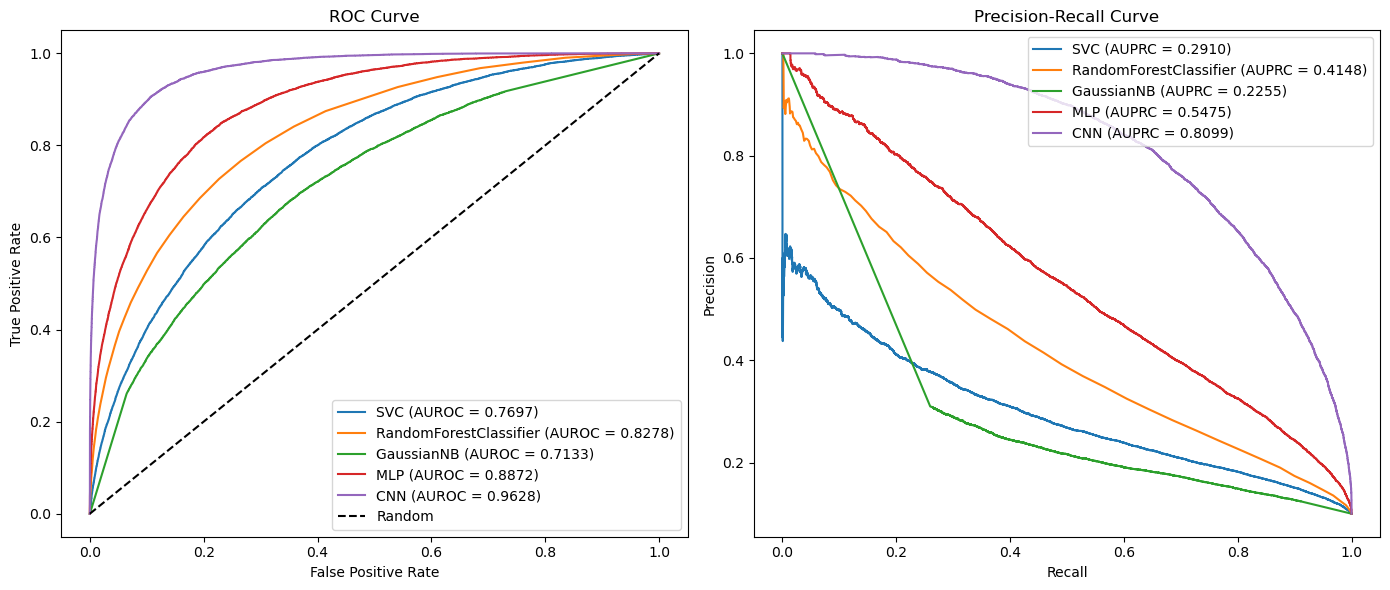

In [16]:
## Plot ROC and P/R curves
jpt.plot_roc_pr_curves(results)

# 4) Model interpretability

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


Feature saliency for MLP


TypeError: Invalid shape (3, 32, 32) for image data

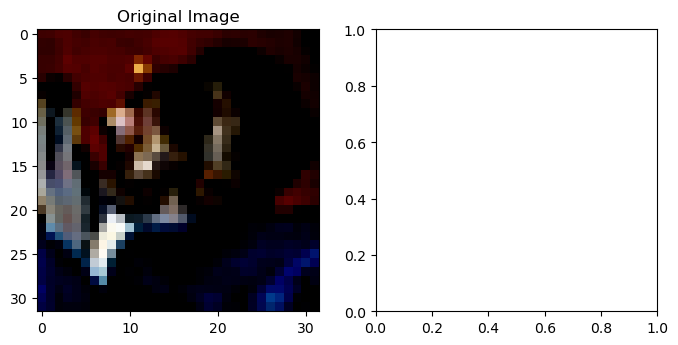

In [24]:
## PyTorch models - input feature saliency
def show_saliency_map(image, saliency):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    # Convert (C, H, W) → (H, W, C)
    img_np = image.permute(1, 2, 0).cpu().numpy()
    axes[0].imshow(img_np)
    axes[0].set_title("Original Image")
    axes[1].imshow(saliency, cmap='hot')
    axes[1].set_title("Saliency Map")
    plt.tight_layout()
    plt.show()
    
# Pick a test image
x, y = test_set[0]

for name, model in torch_models.items():
    print(f"Feature saliency for {name}")
    sal = jpt.compute_saliency(model, x, y)
    show_saliency_map(x, sal)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


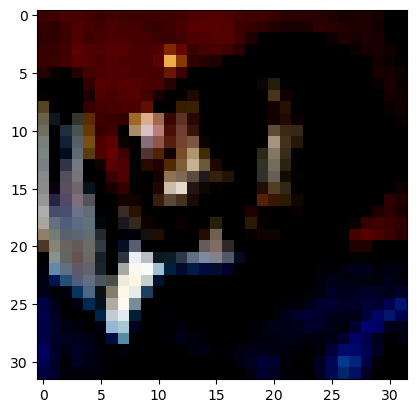

In [27]:
img_np = x.permute(1, 2, 0).cpu().numpy()
plt.imshow(img_np)

In [28]:
y

3

In [19]:
## Look at the structure of the CNN model class
cnn = torch_models['CNN']
cnn

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

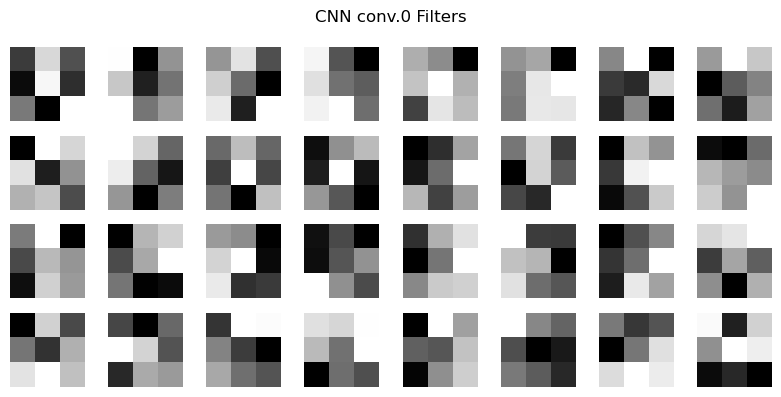

In [20]:
## Visualize the learned filters from the first convolutional layer of the CNN
layer_name = "conv.0"
layer = dict(cnn.named_modules()).get(layer_name, None)

weights = jpt.get_conv_filters(layer)
jpt.plot_conv_filters(weights, title=f"CNN {layer_name} Filters")

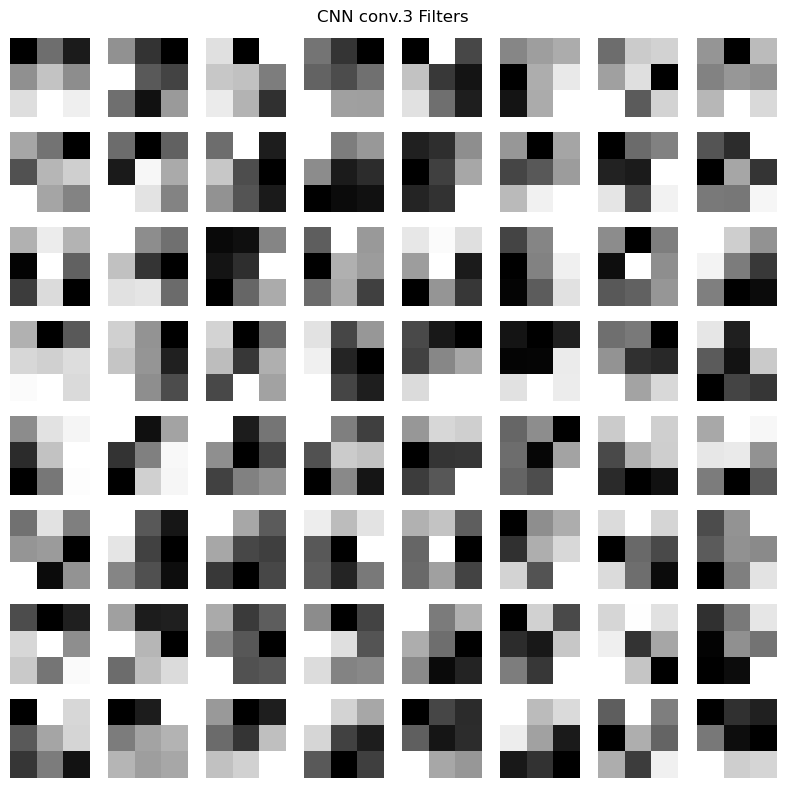

In [21]:
# Plot filters from second convolutional layer
layer_name = "conv.3"
layer = dict(cnn.named_modules()).get(layer_name, None)

weights = jpt.get_conv_filters(layer)
jpt.plot_conv_filters(weights, title=f"CNN {layer_name} Filters")

In [22]:
# Choose a test image to use for visualizing convolutions, activation patterns, and classification logits
img, label = test_set[0]

TypeError: Invalid shape (3, 32, 32) for image data

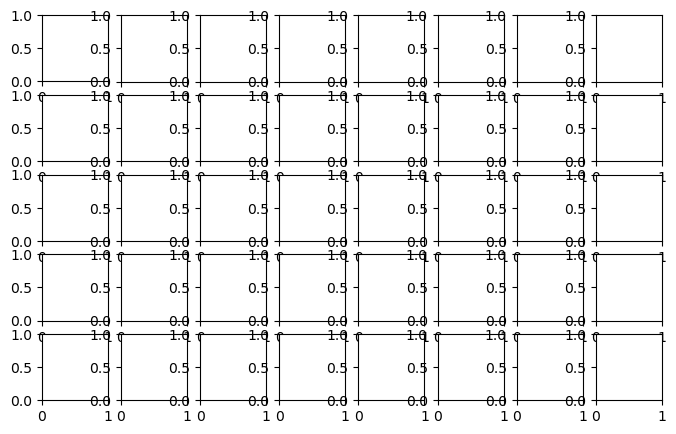

In [23]:
## Visualize the convolutions from the learned filters of the first convolutional layer
layer_name='conv.0'

# Get convolutions
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + convolutions
jpt.plot_feature_maps(img, feature_maps, title=f"{cnn.name} {layer_name} convolutions of input (Label {label})")

In [ ]:
## Visualize the activation patterns from the convolutions

layer_name='conv.1'

# Get activations
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + activations
jpt.plot_feature_maps(img, feature_maps, title=f"{cnn.name} {layer_name} Activations from input (Label {label})")

In [ ]:
## Visualize the max pooling of activations

layer_name='conv.2'

# Get max pooled features
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + max pooled downsampling
jpt.plot_feature_maps(img, feature_maps, title=f"{cnn.name} {layer_name} max pooling of activations (Label {label})")